## Feature Engineering, Class Imbalance, and Modeling

### Library Imports

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries
import os
import time
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.utils.class_weight import compute_class_weight


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Data Loding and Targets

In [4]:
# set the filepath to the parquet cleaned dataset
PATH = r"C:\Users\annas\Downloads\Cleaned_Dataset.parquet"

# scan the parquet file with polars
scan = pl.scan_parquet(PATH)

scan = scan.with_columns([
    pl.col("Label").str.split("-").list.first().alias("Label_Family"),
    pl.when(pl.col("Label") == "BENIGN").then(pl.lit("BENIGN")).otherwise(pl.lit("ATTACK")).alias("Label_Binary"),
])

# get the dataset schema
schema = scan.collect_schema()
all_cols = schema.names()

In [7]:
print(f"Columns detected: {len(all_cols)}")

Columns detected: 42


### Redundancy Pruning (corr > 0.95 on numeric columns)

In [8]:
protected = {"Label", "Label_Family", "Label_Binary"}
numeric_cols = [name for name, dtype in schema.items() if dtype.is_numeric() and name not in protected]
if not numeric_cols:
    raise ValueError("No numeric columns found for redundancy pruning.")

# sample ~1% by row-index stride for speed, cap at 200k rows
sample_pdf = (
    scan.select(numeric_cols)
        .with_row_index("_row")
        .filter((pl.col("_row") % 100) == 0)        # ~1% stride sample
        .select(numeric_cols)
        .limit(200_000)
        .collect()
        .to_pandas()
).astype(float, copy=False)

corr = sample_pdf.corr(method="pearson").abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = {c for c in upper.columns if (upper[c] >= 0.95).any()}
final_cols = [c for c in all_cols if c not in to_drop]
scan_pruned = scan.select(final_cols)

print(f"Dropped {len(to_drop)} features (corr>0.95): {sorted(to_drop)}")
print(f"Remaining: {len(final_cols)} / {len(all_cols)}")


Dropped 6 features (corr>0.95): ['IPv', 'LLC', 'Tot_size', 'fin_count', 'rst_count', 'syn_count']
Remaining: 36 / 42


Redundancy pruning applied a Pearson absolute-correlation screen (threshold = 0.95) and removed highly collinear features identified by the EDA heatmap.

### Feature Engineering 

In [9]:
scan_fe = scan_pruned
EPS = 1e-12
names_now = set(scan_fe.collect_schema().names())

exprs = []

# interactions, traffic intensity, dispersion, flags
if {"Tot_sum","Number"} <= names_now: exprs += [(pl.col("Tot_sum")/(pl.col("Number")+EPS)).alias("bytes_per_packet")]
if {"Rate","Number"} <= names_now:    exprs += [(pl.col("Rate")/(pl.col("Number")+EPS)).alias("rate_per_packet")]
if {"Number","IAT"} <= names_now:     exprs += [(pl.col("Number")/(pl.col("IAT")+EPS)).alias("packets_per_second")]
if {"Tot_sum","Rate"} <= names_now:   exprs += [(pl.col("Tot_sum")/(pl.col("Rate")+EPS)).alias("size_to_rate")]
if {"Std","AVG"} <= names_now:        exprs += [(pl.col("Std")/(pl.col("AVG")+EPS)).alias("std_over_avg")]
if {"Variance","AVG"} <= names_now:   exprs += [(pl.col("Variance")/(pl.col("AVG")+EPS)).alias("var_over_avg")]
if {"Max","Min"} <= names_now:        exprs += [(pl.col("Max")/(pl.col("Min")+EPS)).alias("max_over_min")]
if {"TCP","UDP"} <= names_now:        exprs += [(pl.col("TCP")/(pl.col("UDP")+EPS)).alias("tcp_udp_ratio")]
if {"ICMP","TCP","UDP"} <= names_now: exprs += [(pl.col("ICMP")/(pl.col("TCP")+pl.col("UDP")+EPS)).alias("icmp_over_transport")]

flag_cols = [c for c in ["fin_flag_number","syn_flag_number","rst_flag_number","psh_flag_number",
                         "ack_flag_number","ece_flag_number","cwr_flag_number"] if c in names_now]
if flag_cols:
    s = pl.lit(0)
    for f in flag_cols: s = s + pl.col(f)
    exprs += [s.alias("tcp_flag_sum")]
if {"ack_flag_number","syn_flag_number"} <= names_now:
    exprs += [(pl.col("ack_flag_number")/(pl.col("syn_flag_number")+EPS)).alias("ack_over_syn")]
if {"rst_flag_number","psh_flag_number"} <= names_now:
    exprs += [(pl.col("rst_flag_number")/(pl.col("psh_flag_number")+EPS)).alias("rst_over_psh")]
if {"syn_flag_number","ack_flag_number"} <= names_now:
    exprs += [(pl.col("syn_flag_number")*pl.col("ack_flag_number")).alias("syn_ack_interaction")]

# protocol-conditional rate
if {"Rate","Protocol_Type"} <= names_now:
    exprs += [
        (pl.col("Rate")*(pl.col("Protocol_Type")==6 ).cast(pl.Int8)).alias("rate_tcp_only"),
        (pl.col("Rate")*(pl.col("Protocol_Type")==17).cast(pl.Int8)).alias("rate_udp_only"),
        (pl.col("Rate")*(pl.col("Protocol_Type")==1 ).cast(pl.Int8)).alias("rate_icmp_only"),
        (pl.col("Rate")*(pl.col("Protocol_Type")==47).cast(pl.Int8)).alias("rate_gre_only"),
    ]
    
# header ratios    
if {"Header_Length","Number"} <= names_now:
    exprs += [(pl.col("Header_Length")/(pl.col("Number")+EPS)).alias("header_per_packet")]
if {"Header_Length","AVG"} <= names_now:
    exprs += [(pl.col("Header_Length")/(pl.col("AVG")+EPS)).alias("header_over_avg_size")]

scan_fe = scan_fe.with_columns(exprs)
print(f"Added {len(exprs)} interaction features")

Added 19 interaction features


 Temporal Features

In [ ]:
# temporal bins, extremes for Rate & IAT
names_now = set(scan_fe.collect_schema().names())
temporal_count = 0
if "Rate" in names_now:
    rqs = scan_fe.select([
        pl.col("Rate").quantile(0.25).alias("q1"),
        pl.col("Rate").quantile(0.50).alias("q2"),
        pl.col("Rate").quantile(0.75).alias("q3"),
        pl.col("Rate").quantile(0.99).alias("q99"),
    ]).collect().to_pandas().iloc[0]
    scan_fe = scan_fe.with_columns([
        pl.when(pl.col("Rate")<=rqs.q1).then(0).when(pl.col("Rate")<=rqs.q2).then(1)
          .when(pl.col("Rate")<=rqs.q3).then(2).otherwise(3).cast(pl.Int8).alias("Rate_bin4"),
        (pl.col("Rate")>=float(rqs.q99)).cast(pl.Int8).alias("is_rate_top1pct"),
    ])
    temporal_count += 2

if "IAT" in names_now:
    iqs = scan_fe.select([
        pl.col("IAT").quantile(0.25).alias("q1"),
        pl.col("IAT").quantile(0.50).alias("q2"),
        pl.col("IAT").quantile(0.75).alias("q3"),
        pl.col("IAT").quantile(0.01).alias("q01"),
    ]).collect().to_pandas().iloc[0]
    scan_fe = scan_fe.with_columns([
        pl.when(pl.col("IAT")<=iqs.q1).then(0).when(pl.col("IAT")<=iqs.q2).then(1)
          .when(pl.col("IAT")<=iqs.q3).then(2).otherwise(3).cast(pl.Int8).alias("IAT_bin4"),
        (pl.col("IAT")<=float(iqs.q01)).cast(pl.Int8).alias("is_iat_bottom1pct"),
    ])
    temporal_count += 2

print(f"Added {temporal_count} temporal features")

Added 4 temporal features


Protocol Features

In [10]:
# protocol one-hots and patterns
names_now = set(scan_fe.collect_schema().names())
proto_exprs = []
if "Protocol_Type" in names_now:
    proto_exprs += [
        (pl.col("Protocol_Type")==6 ).cast(pl.Int8).alias("is_tcp"),
        (pl.col("Protocol_Type")==17).cast(pl.Int8).alias("is_udp"),
        (pl.col("Protocol_Type")==1 ).cast(pl.Int8).alias("is_icmp"),
        (pl.col("Protocol_Type")==47).cast(pl.Int8).alias("is_gre"),
    ]
if "syn_flag_number" in names_now: proto_exprs += [(pl.col("syn_flag_number")>0).cast(pl.Int8).alias("has_syn")]
if "ack_flag_number" in names_now: proto_exprs += [(pl.col("ack_flag_number")>0).cast(pl.Int8).alias("has_ack")]
if {"syn_flag_number","ack_flag_number"} <= names_now:
    proto_exprs += [
        ((pl.col("syn_flag_number")>0) & (pl.col("ack_flag_number")==0)).cast(pl.Int8).alias("syn_no_ack"),
        ((pl.col("syn_flag_number")>0) & (pl.col("ack_flag_number")>0)).cast(pl.Int8).alias("syn_and_ack"),
    ]
if proto_exprs:
    scan_fe = scan_fe.with_columns(proto_exprs)
    print(f"Added {len(proto_exprs)} protocol features")

Added 8 protocol features


Zero-Unflation Indicators

In [ ]:
# zero-inflation indicators for sparse ports, counters
candidates = ["HTTP","HTTPS","DNS","SSH","Telnet","SMTP","IRC","DHCP","ARP","ICMP","IGMP","Std","Variance","ack_count","Number"]
present = [c for c in candidates if c in scan_fe.collect_schema().names()]
scan_fe = scan_fe.with_columns([(pl.col(c)==0).cast(pl.Int8).alias(f"is_zero_{c}") for c in present])
print(f"Added {len(present)} zero-inflation indicators")

total_engineered = len(exprs) + temporal_count + len(proto_exprs) + len(present)
print(f"\nTotal engineered features: {total_engineered}")
print(f"Final column count: {len(scan_fe.collect_schema().names())}")

Added 15 zero-inflation indicators

Total engineered features: 46
Final column count: 82


### Modeling Samle (stratified subset)

In [13]:
target = "Label_Family"
feature_cols = [c for c in scan_fe.collect_schema().names() if c not in {"Label","Label_Family","Label_Binary"}]

model_df = (
    scan_fe.with_row_index("_row")
           .filter((pl.col("_row") % 50) == 0)  # ~2% stride
           .select(feature_cols + [target])
           .limit(200_000)
           .collect()
           .to_pandas()
)
model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0).reset_index(drop=True)

print(f"Sample shape: {model_df.shape}")
print(f"Target: {target}")
print("\nClass distribution:\n", model_df[target].value_counts().sort_index())

X = model_df[feature_cols].astype(np.float32, copy=False)
y = model_df[target].astype(str)
le = LabelEncoder()
y_enc = le.fit_transform(y)
print(f"\nClasses: {len(le.classes_)}")

Sample shape: (200000, 61)
Target: Label_Family

Class distribution:
 Label_Family
BACKDOOR_MALWARE            25
BENIGN                    9943
BROWSERHIJACKING            53
COMMANDINJECTION            56
DDOS                    116936
DICTIONARYBRUTEFORCE       130
DNS_SPOOFING              1658
DOS                      39729
MIRAI                    22534
MITM                      2547
RECON                     2894
SQLINJECTION                46
UPLOADING_ATTACK            10
VULNERABILITYSCAN         3404
XSS                         35
Name: count, dtype: int64

Classes: 15


### CV visuals (fold layout & class mixing)

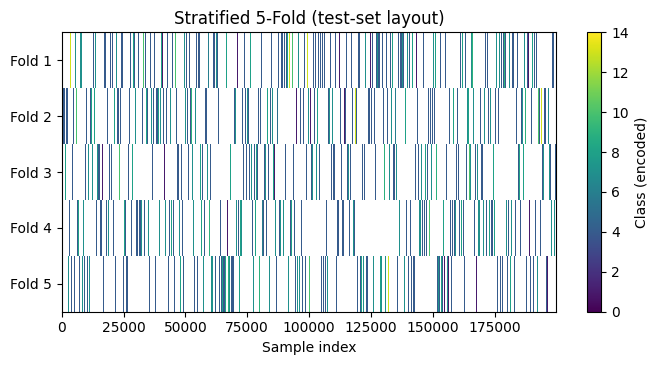

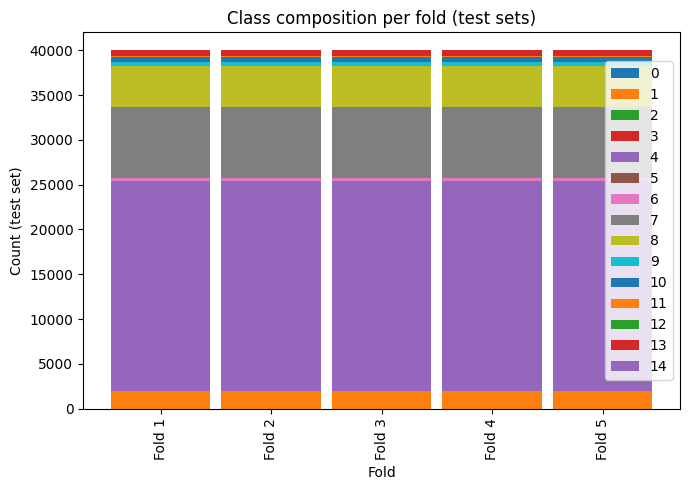

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def plot_stratified_cv_splits(y_enc, cv, title="Stratified 5-Fold (test-set layout)"):
    n_splits = cv.get_n_splits()
    n = len(y_enc)
    Z = np.full((n_splits, n), np.nan)
    for i, (_, test_idx) in enumerate(cv.split(np.zeros(n), y_enc)):
        Z[i, test_idx] = y_enc[test_idx]
    plt.figure(figsize=(7, 2 + 0.35*n_splits))
    im = plt.imshow(Z, aspect="auto", interpolation="nearest")
    plt.colorbar(im, label="Class (encoded)")
    plt.yticks(range(n_splits), [f"Fold {i+1}" for i in range(n_splits)])
    plt.xlabel("Sample index"); plt.title(title); plt.tight_layout(); plt.show()

plot_stratified_cv_splits(y_enc, cv)

# per-fold class composition (test sets)
fold_counts = []
for i, (_, test_idx) in enumerate(cv.split(X, y_enc), 1):
    vc = pd.Series(y_enc[test_idx]).value_counts().sort_index()
    vc.name = f"Fold {i}"
    fold_counts.append(vc)
    
pd.concat(fold_counts, axis=1).fillna(0).astype(int).T.plot(kind="bar", stacked=True, figsize=(7,5), width=0.9)
plt.ylabel("Count (test set)"); plt.xlabel("Fold")
plt.title("Class composition per fold (test sets)")
plt.tight_layout(); plt.show()


### Regularized Random Forest (balanced class weights) and CV

In [21]:
scoring = {
    "f1_macro": "f1_macro",
    "f1_weighted": "f1_weighted",
    "recall_macro": "recall_macro",
    "precision_macro": "precision_macro",
}

# regularization to prevent overfitting
rf_params = dict(
    n_estimators=150,        
    max_depth=10,            
    min_samples_split=50,    
    min_samples_leaf=20,     
    max_features="sqrt",     
    n_jobs=1,                # let cross_validate parallelize
    random_state=RANDOM_STATE,
)

# building the pipeline
rf_pipe = SKPipeline([
    ("scale", RobustScaler(with_centering=False)),
    ("rf", RandomForestClassifier(class_weight="balanced", **rf_params)),
])

# what we're running
print("Pipeline: RobustScaler,  Regularized RF")
print("Regularization applied:")
print("max_depth: 10 (was 20)")
print("min_samples_split: 50 (was 10)")
print("min_samples_leaf: 20 (was 2)")
print("\n Running 5-fold CV...")


cv_res = cross_validate(rf_pipe, X, y_enc, cv=cv, scoring=scoring,
                        return_train_score=True, n_jobs=-1, verbose=1)

def summarize(res, name):
    rows = []
    for m in scoring.keys():
        test_s = res[f"test_{m}"]
        train_s = res[f"train_{m}"]
        rows.append([name, m, test_s.mean(), test_s.std(), train_s.mean(), train_s.mean() - test_s.mean()])
    return pd.DataFrame(rows, columns=["Model","Metric","Test_Mean","Test_Std","Train_Mean","Gap"])

summary = summarize(cv_res, "RF(regularized)")
print("\n" + summary.to_string(index=False))

Pipeline: RobustScaler,  Regularized RF
Regularization applied:
max_depth: 10 (was 20)
min_samples_split: 50 (was 10)
min_samples_leaf: 20 (was 2)

 Running 5-fold CV...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished



          Model          Metric  Test_Mean  Test_Std  Train_Mean      Gap
RF(regularized)        f1_macro   0.376523  0.002665    0.461502 0.084979
RF(regularized)     f1_weighted   0.727908  0.002321    0.730683 0.002775
RF(regularized)    recall_macro   0.431405  0.007246    0.805243 0.373839
RF(regularized) precision_macro   0.394880  0.002205    0.446230 0.051350



Classification Report (RF):
                      precision    recall  f1-score   support

    BACKDOOR_MALWARE     0.0000    0.0000    0.0000         2
              BENIGN     0.8552    0.6298    0.7254       994
    BROWSERHIJACKING     0.0000    0.0000    0.0000         5
    COMMANDINJECTION     0.0652    0.5000    0.1154         6
                DDOS     0.9718    0.5915    0.7354     11694
DICTIONARYBRUTEFORCE     0.0693    0.5385    0.1228        13
        DNS_SPOOFING     0.5737    0.6566    0.6124       166
                 DOS     0.4412    0.9494    0.6024      3973
               MIRAI     0.9956    0.9938    0.9947      2253
                MITM     0.6513    0.6078    0.6288       255
               RECON     0.7362    0.4152    0.5310       289
        SQLINJECTION     0.0000    0.0000    0.0000         5
    UPLOADING_ATTACK     0.0000    0.0000    0.0000         1
   VULNERABILITYSCAN     0.4334    0.5647    0.4904       340
                 XSS     0.0000    0.000

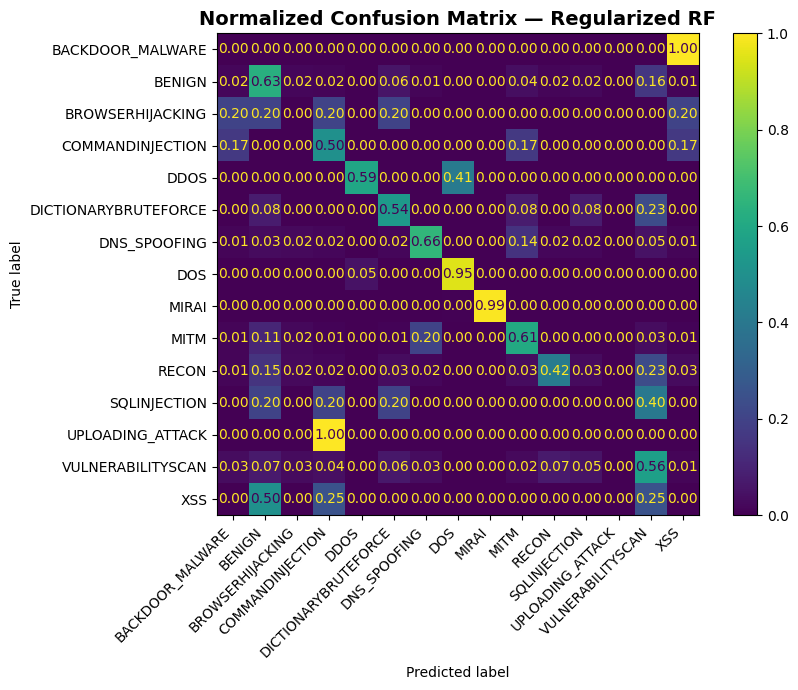

In [41]:
# holdout (10%) report & confusion matrix 
labels_all = np.arange(len(le.classes_))  

Xtr, Xte, ytr, yte = train_test_split(
    X, y_enc, test_size=0.10, stratify=y_enc, random_state=RANDOM_STATE
)

rf_pipe.fit(Xtr, ytr)
yhat = rf_pipe.predict(Xte)

print("\nClassification Report (RF):")
print(classification_report(
    yte, yhat,
    labels=labels_all,                
    target_names=le.classes_,         
    digits=4,
    zero_division=0
))

fig, ax = plt.subplots(figsize=(9, 7))
ConfusionMatrixDisplay.from_predictions(
    yte, yhat,
    labels=labels_all,               
    display_labels=le.classes_,      
    normalize='true',
    values_format=".2f",
    ax=ax
)
ax.set_title("Normalized Confusion Matrix — Regularized RF", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Multi - Model Comparison (RF, Gradient Boosting, LightGBM)


 With and without log1p transforms for skewed features.


In [23]:
# Identifying skewed features (using a sample for speed)
sample_size = min(50_000, len(X))
X_sample = X.sample(n=sample_size, random_state=RANDOM_STATE)
skewness = X_sample.skew()
highly_skewed = skewness[abs(skewness) > 2].sort_values(ascending=False)

log_transform_candidates = [c for c in highly_skewed.index if (X[c] >= 0).all()]
print(f"Highly skewed (|skew|>2): {len(highly_skewed)}")
print(f"Log1p candidates (non-negative): {len(log_transform_candidates)}")
if log_transform_candidates:
    print("  Examples:", log_transform_candidates[:5])

Highly skewed (|skew|>2): 46
Log1p candidates (non-negative): 46
  Examples: ['size_to_rate', 'IAT', 'rate_per_packet', 'SMTP', 'Telnet']


In [30]:
# build log-transformed copy if applicable
X_log = X.copy()
for col in log_transform_candidates:
    X_log[col] = np.log1p(X_log[col])
    
# define models
models = {
    "Random Forest": SKPipeline([
        ("scale", RobustScaler(with_centering=False)),
        ("clf", RandomForestClassifier(
            n_estimators=150, max_depth=10, min_samples_split=50, min_samples_leaf=20,
            max_features="sqrt", class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
        ))
    ]),
    "Gradient Boosting": SKPipeline([
        ("scale", RobustScaler(with_centering=False)),
        ("clf", GradientBoostingClassifier(
            n_estimators=120, learning_rate=0.08, max_depth=5,
            min_samples_split=40, min_samples_leaf=15, subsample=0.8,
            random_state=RANDOM_STATE
        ))
    ]),
}  

# checking LightGBM availability
USE_LGBM = True
try:
    from lightgbm import LGBMClassifier
except Exception:
    USE_LGBM = False
                                                                        
if USE_LGBM:
    models["LightGBM"] = SKPipeline([
        ("scale", RobustScaler(with_centering=False)),
        ("clf", LGBMClassifier(
            n_estimators=200, learning_rate=0.08, max_depth=7,
            num_leaves=31, min_child_samples=20, subsample=0.8, colsample_bytree=0.8,
            class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE, verbose=-1
        ))
    ])    

In [ ]:
# CV (3-fold for speed)
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
scoring_small = {"f1_macro": "f1_macro", "f1_weighted": "f1_weighted"}

results = {}
for name, pipe_ in models.items():
    # Original
    t0 = time.time()
    res = cross_validate(pipe_, X, y_enc, cv=cv3, scoring=scoring_small,
                         return_train_score=True, n_jobs=-1, verbose=0)
    t1 = time.time() - t0
    results[name] = {
        "test_f1_macro": res["test_f1_macro"].mean(),
        "test_f1_weighted": res["test_f1_weighted"].mean(),
        "train_f1_macro": res["train_f1_macro"].mean(),
        "gap": res["train_f1_macro"].mean() - res["test_f1_macro"].mean(),
        "time": t1,
        "transform": "Original"
    }
    print(f"{name:>17s} — F1_macro: {results[name]['test_f1_macro']:.4f}  gap: {results[name]['gap']:.4f}  time: {t1:.1f}s")

In [ ]:
# Log
if log_transform_candidates:
    t0 = time.time()
    resL = cross_validate(pipe_, X_log, y_enc, cv=cv3, scoring=scoring_small,
                              return_train_score=True, n_jobs=-1, verbose=0)
    t1 = time.time() - t0
    results[name + " (Log)"] = {
            "test_f1_macro": resL["test_f1_macro"].mean(),
            "test_f1_weighted": resL["test_f1_weighted"].mean(),
            "train_f1_macro": resL["train_f1_macro"].mean(),
            "gap": resL["train_f1_macro"].mean() - resL["test_f1_macro"].mean(),
            "time": t1,
            "transform": "Log"
    }
    delta = results[name + " (Log)"]["test_f1_macro"] - results[name]["test_f1_macro"]
    print(f"{name:>17s} (Log) — F1_macro: {results[name + ' (Log)']['test_f1_macro']:.4f}  Δ:{delta:+.4f}  time: {t1:.1f}s")

In [ ]:
# results table and visuals
results_df = pd.DataFrame(results).T.sort_values("test_f1_macro", ascending=False)
print("\nModel ranking by F1-macro:\n")
print(results_df.to_string())

In [ ]:
# bar plot — F1 macro
plt.figure(figsize=(10,5))
order = results_df.sort_values("test_f1_macro", ascending=True)
colors = ["steelblue" if "(Log)" not in idx else "coral" for idx in order.index]
plt.barh(range(len(order)), order["test_f1_macro"], color=colors, alpha=0.8)
plt.xlabel("F1-Macro"); plt.title("Model Performance Comparison")
plt.yticks(range(len(order)), order.index)
for i, v in enumerate(order["test_f1_macro"]):
    plt.text(v+0.003, i, f"{v:.4f}", va="center", fontsize=9)
plt.tight_layout(); plt.show()

In [ ]:
# gap plot
plt.figure(figsize=(10,4))
plt.bar(range(len(results_df)), results_df["gap"], color="gray", alpha=0.8)
plt.xticks(range(len(results_df)), results_df.index, rotation=45, ha="right")
plt.ylabel("Train–Test Gap"); plt.title("Overfitting Analysis (smaller is better)")
plt.tight_layout(); plt.show()

In [ ]:
# train best model on holdout and show matrices
best_name = results_df["test_f1_macro"].idxmax()
use_log = "(Log)" in best_name
base_name = best_name.replace(" (Log)", "")
X_final = X_log if use_log else X
best_pipe = models[base_name]

print("\n" + "="*60)
print("STEP 9: BEST MODEL HOLDOUT")
print("="*60)
print(f"Best model: {best_name}")

Xtr, Xte, ytr, yte = train_test_split(
    X_final, y_enc, test_size=0.15, stratify=y_enc, random_state=RANDOM_STATE
)
best_pipe.fit(Xtr, ytr)
yhat = best_pipe.predict(Xte)

print("\nClassification Report (BEST):")
print(classification_report(
    yte, yhat, labels=labels_all, target_names=le.classes_, digits=4, zero_division=0
))

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# normalized
cmN = confusion_matrix(yte, yhat, labels=labels_all, normalize="true")
sns.heatmap(cmN, annot=True, fmt=".2f", cmap="Blues", ax=axes[0],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title(f"Normalized Confusion Matrix — {best_name}")
axes[0].tick_params(axis='x', rotation=45)

# raw
cmR = confusion_matrix(yte, yhat, labels=labels_all)
sns.heatmap(cmR, annot=True, fmt="d", cmap="Oranges", ax=axes[1],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_title(f"Raw Confusion Matrix — {best_name}")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(); plt.show()